# LOCAL RAG PIPELINE
PDF source: https://pressbooks.oer.hawaii.edu/humannutrition2/


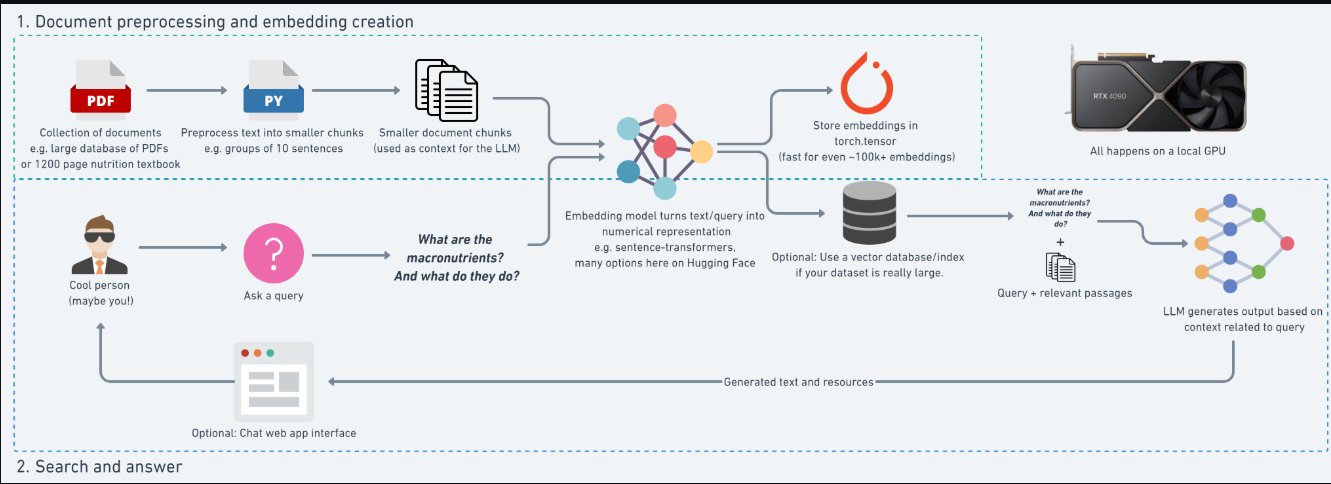

# NUTRIENT CHAT : Chat With Nutrition TextBook

Step 1) Open a PDF Document

Step 2) Format the text of the PDF textbook ready for the Embedding Model

Step 3) Embed all the chunks of text and turn them into numerical represenation (embeddings) which can store for later

Step 4) Build a retrieval search system that uses VECTOR search to find relevent chunk of text based on a query

Step 5) Create a prompt that incorporates the retrived pieces of text

Step 6) Generate an answer to a query based on the passages of the textbook with an LLM

## 1. Document/Text Processing and Embedding Creation

* Requirements
1) PDF DOCUMENT

2) Embedding Model

* STEPS:
1) Import PDF DOCUMENT
2) Process Text(Split into chunks)
3) Embed text chunks with embedding Model
4) Save Embeddings to file for later
               

In [ ]:
# Importing PDF
import os
import requests

pdfPath = "human-nutrition-text.pdf"
if not os.path.exists(pdfPath):
  print(f"Downloading")

  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
  filename = pdfPath

  # Sending GET request to URL
  response = requests.get(url)
  if response.status_code == 200:
    # Open the file and save it
    with open(filename, 'wb') as file:
      file.write(response.content)
    print("File Downloaded", filename)
  else:
    print(f"Failed to download file. Status code: {response.status_code}")
else:
  print(f"[INFO] File Already Exists")

Downloading
File Downloaded human-nutrition-text.pdf


## Opening PDF using PyMuPDF Library

Link: https://github.com/pymupdf/PyMuPDF

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 63.0 MB/s eta 0:00:00


*  "Page Token Count" : len(cleanedText) / 4

This is just rough approximation it works well for small experiments but for GPT they are inaccurate as GPT models use Byte Pair Encoding so instead of this we will use Byte Pair Encoding
using Tiktoken Library


In [ ]:
import tiktoken
from tqdm.auto import tqdm
import fitz

encoding = tiktoken.encoding_for_model("gpt2")

def textFormatter(text: str) -> str:
    cleanedtext = text.replace("\n", " ").strip()
    return cleanedtext

def openReadPDF(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_Text = []
    for pageNum, page in tqdm(enumerate(doc)):
        text = page.get_text("text")
        cleanedText = textFormatter(text)
        pages_Text.append({
            "Page Number": pageNum,
            "Page Characater Count" : len(cleanedText),
            "Page Word Count" : len(cleanedText.split(" ")),
            "Page Sentences Count" : len(cleanedText.split(". ")),
            # Page Token Count" : len(cleanedText) / 4
            "Page Token Count" : len(encoding.encode(cleanedText)),
            "Text": cleanedText
        })
    return pages_Text

pages_Text = openReadPDF(pdfPath)
pages_Text[:2]


0it [00:00, ?it/s]

[{'Page Number': 0,
  'Page Characater Count': 29,
  'Page Word Count': 4,
  'Page Sentences Count': 1,
  'Page Token Count': 5,
  'Text': 'Human Nutrition: 2020 Edition'},
 {'Page Number': 1,
  'Page Characater Count': 0,
  'Page Word Count': 1,
  'Page Sentences Count': 1,
  'Page Token Count': 0,
  'Text': ''}]

In [ ]:
import random
random.sample(pages_Text, k = 3)

[{'Page Number': 685,
  'Page Characater Count': 492,
  'Page Word Count': 82,
  'Page Sentences Count': 4,
  'Page Token Count': 119,
  'Text': 'downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=370  \xa0 644  |  Magnesium'},
 {'Page Number': 10,
  'Page Characater Count': 973,
  'Page Word Count': 177,
  'Page Sentences Count': 2,
  'Page Token Count': 235,
  'Text': 'Nonessential and Essential Fatty Acids  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  313  Digestion and Absorption of Lipids  University of Hawai‘i 

In [ ]:
# Converting Data Into Dataframes
import pandas as pd
df = pd.DataFrame(pages_Text)
df.head()

,Page Number,Page Characater Count,Page Word Count,Page Sentences Count,Page Token Count,Text
0,0,29,4,1,5,Human Nutrition: 2020 Edition
1,1,0,1,1,0,
2,2,320,54,1,142,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,3,212,32,1,43,Human Nutrition: 2020 Edition by University of...
4,4,797,145,2,194,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df.describe().round(2)

,Page Number,Page Characater Count,Page Word Count,Page Sentences Count,Page Token Count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,9.97,273.48
std,348.86,560.38,95.76,6.19,128.62
min,0.00,0.00,1.00,1.00,0.00
25%,301.75,762.00,134.00,4.00,178.50
50%,603.50,1231.50,214.50,10.00,295.50
75%,905.25,1603.50,271.00,14.00,372.00
max,1207.00,2308.00,429.00,32.00,611.00


# SPLITTING PAGES INTO SENTENCES

* Two Ways
  1) Splitting on the basis of ". "
  2) Using NLP library such as spaCy or nltk

In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")

doc = nlp("This is a sample sentence. This is another sentence. I like Food.")
assert len(list(doc.sents)) == 3
print(list(doc.sents))


[This is a sample sentence., This is another sentence., I like Food.]


In [ ]:
for item in tqdm(pages_Text):
  item["sentences"] = list(nlp(item["Text"]).sents)
  # By default type is spaCy datatype so convert into strings
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  item["pageSentencesCount"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_Text, k = 3)

[{'Page Number': 714,
  'Page Characater Count': 974,
  'Page Word Count': 197,
  'Page Sentences Count': 15,
  'Page Token Count': 283,
  'Text': 'Food  Serving  Zinc (mg) Percent Daily Value  Oysters  3 oz.  74  493  Beef, chuck roast 3 oz.  7  47  Crab  3 oz.  6.5  43  Lobster  3 oz.  3.4  23  Pork loin  3 oz.  2.9  19  Baked beans  ½ c.  2.9  19  Yogurt, low fat  8 oz.  1.7  11  Oatmeal, instant  1 packet 1.1  7  Almonds  1 oz.  0.9  6  Fact Sheet for Health Professionals: Zinc. National Institute of  Health, Office of Dietary Supplements. https://ods.od.nih.gov/ factsheets/Zinc-HealthProfessional/. Updated February 11, 2016.  Accessed November 10, 2017.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learn

In [ ]:
df1 = pd.DataFrame(pages_Text)
df1.head()

,Page Number,Page Characater Count,Page Word Count,Page Sentences Count,Page Token Count,Text,sentences,pageSentencesCount
0,0,29,4,1,5,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1
1,1,0,1,1,0,,[],0
2,2,320,54,1,142,Human Nutrition: 2020 Edition UNIVERSITY OF ...,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1
3,3,212,32,1,43,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1
4,4,797,145,2,194,Contents Preface University of Hawai‘i at Mā...,[Contents Preface University of Hawai‘i at M...,2


In [ ]:
df1.describe().round(2)

,Page Number,Page Characater Count,Page Word Count,Page Sentences Count,Page Token Count,pageSentencesCount
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,9.97,273.48,10.32
std,348.86,560.38,95.76,6.19,128.62,6.30
min,0.00,0.00,1.00,1.00,0.00,0.00
25%,301.75,762.00,134.00,4.00,178.50,5.00
50%,603.50,1231.50,214.50,10.00,295.50,10.00
75%,905.25,1603.50,271.00,14.00,372.00,15.00
max,1207.00,2308.00,429.00,32.00,611.00,28.00


# TEXT CHUNKING

There are better frameworks like langchain which can help but for RAG Implimentation we will stick with Python

In [ ]:
chunkSize = 10
'Function to split lists of text recursively into chunk size'
def splitList(
    inputList : list,
    sliceSize : int=chunkSize) -> list[list[str]]:
    return [inputList[i:i+sliceSize] for i in range(0, len(inputList), sliceSize)]
testingList = list(range(25))
splitList(testingList)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
for item in tqdm(pages_Text):
  item["chunkedSentences"] = splitList(item["sentences"], sliceSize=chunkSize)
  item["numOfChunks"] = len(item["chunkedSentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_Text, k=2)

[{'Page Number': 509,
  'Page Characater Count': 560,
  'Page Word Count': 95,
  'Page Sentences Count': 6,
  'Page Token Count': 135,
  'Text': 'In a much less severe example, a person is also in negative-energy  balance between meals. During this time, blood-glucose levels start  to drop. In order to restore blood-glucose levels to their normal  range, the anabolic pathway, called gluconeogenesis, is stimulated.  Gluconeogenesis is the process of building glucose molecules  mostly from certain amino acids and it occurs primarily in the liver  (Figure 8.5 “Metabolic Pathway of Gluconeogenesis”). The liver  exports the synthesized glucose into the blood for other tissues to  use.  468  |  The Atom',
  'sentences': ['In a much less severe example, a person is also in negative-energy  balance between meals.',
   'During this time, blood-glucose levels start  to drop.',
   'In order to restore blood-glucose levels to their normal  range, the anabolic pathway, called gluconeogenesis, is st

In [ ]:
df2 = pd.DataFrame(pages_Text)
df2.describe().round(2)


,Page Number,Page Characater Count,Page Word Count,Page Sentences Count,Page Token Count,pageSentencesCount,numOfChunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,9.97,273.48,10.32,1.53
std,348.86,560.38,95.76,6.19,128.62,6.30,0.64
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,301.75,762.00,134.00,4.00,178.50,5.00,1.00
50%,603.50,1231.50,214.50,10.00,295.50,10.00,1.00
75%,905.25,1603.50,271.00,14.00,372.00,15.00,2.00
max,1207.00,2308.00,429.00,32.00,611.00,28.00,3.00


### Splitting Each Chunk into its own item

In [ ]:
import re
'Split each chunk into its own items'
pages_chunks = []
for item in tqdm(pages_Text):
  for sentenceChunk in item["chunkedSentences"]:
    chunkDict = {}
    chunkDict["Page Number"] = item["Page Number"]

    # Joining list of sentences into one paragraph
    joinedSentencesChunk = "".join(sentenceChunk).replace("  "," ").strip()
    joinedSentencesChunk = re.sub(r'\.([A-Z])',r'.\1', joinedSentencesChunk)
    chunkDict["sentencesChunk"] = joinedSentencesChunk

    chunkDict["chunkedCharacterCount"] = len(joinedSentencesChunk)
    chunkDict["chunkedWordCount"] = len(joinedSentencesChunk.split())
    chunkDict["chunkedTokenCounts"] = len(encoding.encode(joinedSentencesChunk))
    pages_chunks.append(chunkDict)
print(len(pages_chunks))

  0%|          | 0/1208 [00:00<?, ?it/s]

1843


In [ ]:
random.sample(pages_chunks, k=1)

[{'Page Number': 288,
  'sentencesChunk': '2009).\xa0Dietary Glycemic Index: Digestion and Absorption of Carbohydrates | 247',
  'chunkedCharacterCount': 78,
  'chunkedWordCount': 11,
  'chunkedTokenCounts': 22}]

In [ ]:
dfChunked = pd.DataFrame(pages_chunks)
dfChunked.describe().round(2)

,Page Number,chunkedCharacterCount,chunkedWordCount,chunkedTokenCounts
count,1843.00,1843.00,1843.00,1843.00
mean,624.38,731.11,109.23,162.36
std,347.79,445.65,69.37,93.37
min,0.00,12.00,3.00,3.00
25%,321.50,313.50,43.00,82.00
50%,627.00,745.00,111.00,163.00
75%,931.00,1112.00,167.50,236.00
max,1207.00,1824.00,290.00,531.00


###FILTERIING CHUNKS OF TEXT FOR SHORT CHUNKS

These chunks may not contain much useful information

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in dfChunked[dfChunked["chunkedTokenCounts"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunkedTokenCounts"]} | Text: {row[1]["sentencesChunk"]}')

Chunk token count: 16 | Text: Health Consequences and Benefits of High-Carbohydrate Diets | 267
Chunk token count: 26 | Text: Journal of the American Dietetic Association. 105(6), 929-36. Calories In Versus Calories Out | 1071
Chunk token count: 21 | Text: There are several lecithin supplements on the market Nonessential and Essential Fatty Acids | 315
Chunk token count: 22 | Text: However, there are also some things that people can do to target specific concerns.One Middle Age | 915
Chunk token count: 9 | Text: Water-Soluble Vitamins | 553


In [ ]:
# Filtering Data
pages_chunksModified = dfChunked[dfChunked["chunkedTokenCounts"] > min_token_length].to_dict(orient = "records")
print(len(pages_chunksModified))
print(pages_chunksModified[:2])

1697
[{'Page Number': 2, 'sentencesChunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE', 'chunkedCharacterCount': 308, 'chunkedWordCount': 42, 'chunkedTokenCounts': 130}, {'Page Number': 3, 'sentencesChunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.', 'chunkedCharacterCount': 210, 'chunkedWordCount': 30, 'chunkedTokenCounts': 41}]


In [ ]:
random.sample(pages_chunksModified, k=2)

[{'Page Number': 514,
  'sentencesChunk': 'Accessed September 22, 2017. 2.\xa0Hawaii State Obesity Data, Rates, and Trends.\xa0 The State of Obesity: Better Policies for a Healthier America. https://stateofobesity.org/states/hi/. Published August 2017.Accessed September 22, 2017. Weight Management | 473',
  'chunkedCharacterCount': 255,
  'chunkedWordCount': 33,
  'chunkedTokenCounts': 64},
 {'Page Number': 79,
  'sentencesChunk': '2000).Developing an Evidence- Based Guide to Community Preventive Services—Methods.Am J Prev Med,\xa018(1S), 35–43. https://www.ncbi.nlm.nih.gov/pubmed/10806978 38 | Research and the Scientific Method',
  'chunkedCharacterCount': 197,
  'chunkedWordCount': 22,
  'chunkedTokenCounts': 59}]

## Embedding Processed Text Chunks
https://huggingface.co/sentence-transformers


In [ ]:
pip install -U sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embeddingModel = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device = "cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sampleSentences = ["The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium."]
embeddings = embeddingModel.encode(sampleSentences)
print(embeddings.shape)
embeddingsDict = dict(zip(sampleSentences, embeddings))

for sentence, embedding in embeddingsDict.items():
    print(sentence)
    print(embedding)
    print()

(3, 768)
The weather is lovely today.
[-5.40592968e-02 -1.71849374e-02 -3.55374031e-02  5.00999354e-02
  2.86727794e-03 -3.25625688e-02 -5.80761731e-02  6.15105638e-03
  4.56210151e-02  1.85950398e-02 -4.00721394e-02  8.92390460e-02
 -2.16216948e-02 -3.36239785e-02  1.08702611e-02 -1.05172299e-01
  2.24103928e-02 -3.19909602e-02 -2.49627661e-02  1.63077079e-02
 -2.65986007e-03 -3.24465893e-02  3.21150534e-02 -3.25165093e-02
  5.64085543e-02 -1.06154103e-02 -1.73121206e-02  2.34713610e-02
  2.92384848e-02  2.48269252e-02 -5.33476323e-02 -4.08825539e-02
  6.37525469e-02 -4.49078828e-02  1.85175077e-06  1.37187019e-02
  2.81288978e-02 -2.68433895e-03  6.23044632e-02 -7.46229962e-02
 -1.49292732e-02 -2.04746872e-02 -1.56179685e-02  2.33425219e-02
 -6.32121402e-04  4.30108830e-02 -4.29195426e-02 -1.75441559e-02
 -2.68616471e-02  3.05798799e-02 -8.29362776e-03 -2.93245334e-02
 -3.83486003e-02  1.85985696e-02 -1.81627162e-02  2.91873571e-02
  2.34621707e-02 -6.75667673e-02  1.49492547e-02  1.

In [ ]:
%%time
embeddingModel.to("cuda")
for item in tqdm(pages_chunksModified):
  item["embedding"] = embeddingModel.encode(item["sentencesChunk"])

  0%|          | 0/1697 [00:00<?, ?it/s]

CPU times: user 29 s, sys: 182 ms, total: 29.2 s
Wall time: 30.5 s


In [ ]:
%%time

textChunks = [item["sentencesChunk"] for item in pages_chunksModified]
textChunks[419]

CPU times: user 514 µs, sys: 0 ns, total: 514 µs
Wall time: 637 µs


'Enriched wheat flour refers to white flour with added vitamins.)Eat less of products that list HFCS and other sugars such as sucrose, honey, dextrose, and cane sugar in the first five ingredients.If you want to eat less processed foods then, in general, stay away from products with 274 | Carbohydrates and Personal Diet Choices'

In [ ]:
len(textChunks)

1697

In [ ]:
%%time

#Embedding all texts in batches

textChunksEmbeddings = embeddingModel.encode(textChunks, batch_size=8, convert_to_tensor=True)
textChunksEmbeddings

CPU times: user 21.3 s, sys: 54.2 ms, total: 21.3 s
Wall time: 21.7 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
textChunksEmbeddings.shape

torch.Size([1697, 768])

# Saving Embeddings to FILE

1) Method 1: Using Pandas DataFrames
2) Method 2: Using Vector DB

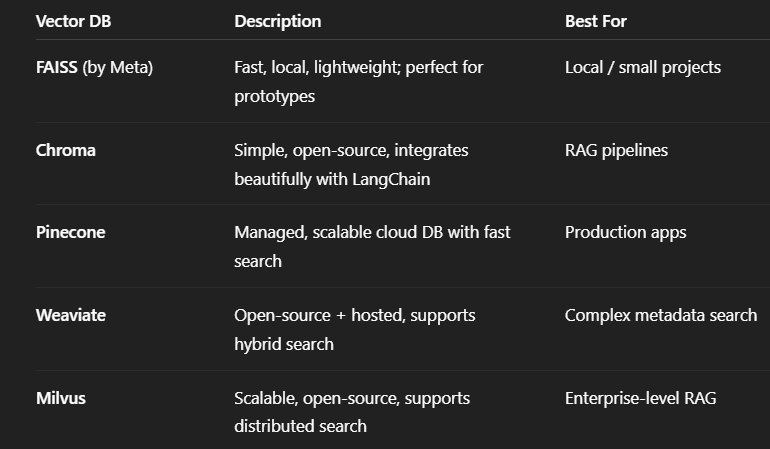

In [ ]:
# Method 1) Saving into DataFrame
embeddingsDf = pd.DataFrame(pages_chunksModified)
embeddingsDfPath = "chunksAndEmbeddings.csv"
embeddingsDf.to_csv(embeddingsDfPath, index = False)

In [ ]:
# Importing Saved CSV file and view
embeddingsDfLoad = pd.read_csv(embeddingsDfPath)
embeddingsDfLoad.head()

,Page Number,sentencesChunk,chunkedCharacterCount,chunkedWordCount,chunkedTokenCounts,embedding
0,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,130,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,3,Human Nutrition: 2020 Edition by University of...,210,30,41,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,4,Contents Preface University of Hawai‘i at Māno...,765,115,163,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,5,Lifestyles and Nutrition University of Hawai‘i...,940,143,199,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,6,The Cardiovascular System University of Hawai‘...,998,152,210,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


* If Embedding data is really large(100k-1M Samples) use VectorDB for strorage

## 2. RAG - Search and Answer
* RAG Goal: Retrive relevent passages based on query and use those passages to augment an input to an LLM so it can generate an output based on those relevent passages

### SIMILARITY SEARCH
* Comapring Embeddings is known as similarity search, vector search, sementic search



In [ ]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import embeddings dataframe
textChunksEmbeddingsDf = pd.read_csv("chunksAndEmbeddings.csv")

# Convert the 'embedding' column from string → numpy array
textChunksEmbeddingsDf["embedding"] = textChunksEmbeddingsDf["embedding"].apply(lambda x : np.fromstring(x.strip("[]"), sep = " "))

# Converting our embeddings into torch.tensor
embeddingsList = torch.tensor(np.stack(textChunksEmbeddingsDf["embedding"].to_list(), axis = 0), dtype=torch.float32).to(device)

# Converting texts and embeddings df to list of dict
pages_chunk = textChunksEmbeddingsDf.to_dict(orient = "records")

In [ ]:
textChunksEmbeddingsDf.head()

,Page Number,sentencesChunk,chunkedCharacterCount,chunkedWordCount,chunkedTokenCounts,embedding
0,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,130,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,3,Human Nutrition: 2020 Edition by University of...,210,30,41,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,4,Contents Preface University of Hawai‘i at Māno...,765,115,163,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,5,Lifestyles and Nutrition University of Hawai‘i...,940,143,199,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,6,The Cardiovascular System University of Hawai‘...,998,152,210,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [ ]:
textChunksEmbeddingsDf["embedding"]

,embedding
0,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...
1692,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1693,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1694,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1695,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [ ]:
print(embeddingsList.shape)
embeddingsList


torch.Size([1697, 768])


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Sementic Search Pipeline
* Search for query and get back relevent passages from our textbook

@ STEPS
* Define a query String
* Turn query into embeddings(Same Model For Passage and query Embeddings)
* Perform Dot Product (Cosine Similarity) between text and query embeddings
* Sort the results from 3 in descending order


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
embeddingModel = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

# Step 1
query = "macronutrients functions"
print(f"Query: {query}")

# Step 2: (Embed Both Text data and embeddings with same model)
queryEmbedding = embeddingModel.encode(query, convert_to_tensor=True)

# Step 3: Perform Cosine Similarity
from time import perf_counter as timer
startTime = timer()
dotScores = util.dot_score(a=queryEmbedding, b=embeddingsList)[0]
endTime = timer()
print(f"Time Taken to get scores on {len(embeddingsList)} embeddings: {endTime-startTime:.5f} seconds.")

# Step 4: Get the top-k Results(k = 5)
topResultsDotProduct = torch.topk(dotScores, k=5)
print(topResultsDotProduct)

Query: macronutrients functions
Time Taken to get scores on 1697 embeddings: 0.00033 seconds.
torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))


* As our dataset is small time taken to calculate dot scores is 0.00022 seconds but if we have 10M+ embeddings, we need to create an index

* Index is like letters in dictionary.
Example: To Search Duck, You'd start with letter "d" then "du" then so on

* Index helps to narrow down the search  
Popular Indexing Library: https://github.com/facebookresearch/faiss

* So Index No 42 or Chunk 42 Has higest similarity score with the query

Below is the Text Chunk 42

In [ ]:
pages_chunk[42]

{'Page Number': 46,
 'sentencesChunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients.There are three classes of macronutrients: carbohydrates, lipids, and proteins.These can be metabolically processed into cellular energy.The energy from macronutrients comes from their chemical bonds.This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.A unit of measurement of food energy is the calorie.On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand.A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels.Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon, hy

Making Vector Search Results Pretty

In [ ]:
import textwrap
def printWrapped(text, wrapLen = 80):
  wrappedText = textwrap.fill(text, wrapLen)
  print(wrappedText + "\n\n")

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(topResultsDotProduct[0], topResultsDotProduct[1]):
  print(f"Score: {score:.4f}")
  print("Text:")
  printWrapped(pages_chunk[idx]["sentencesChunk"])
  print(f"Page Number: {pages_chunk[idx]['Page Number']}")
  print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients.There are three classes of macronutrients: carbohydrates, lipids,
and proteins.These can be metabolically processed into cellular energy.The
energy from macronutrients comes from their chemical bonds.This chemical energy
is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions.A unit of measurement of
food energy is the calorie.On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand.A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels.Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are molecule

### We can improve the order of top results using a RERANKING Model (eg: top 25 sementic results) and rank tehm in order from most likey top-1 to least likely

https://www.mixedbread.com/blog/mxbai-rerank-v1

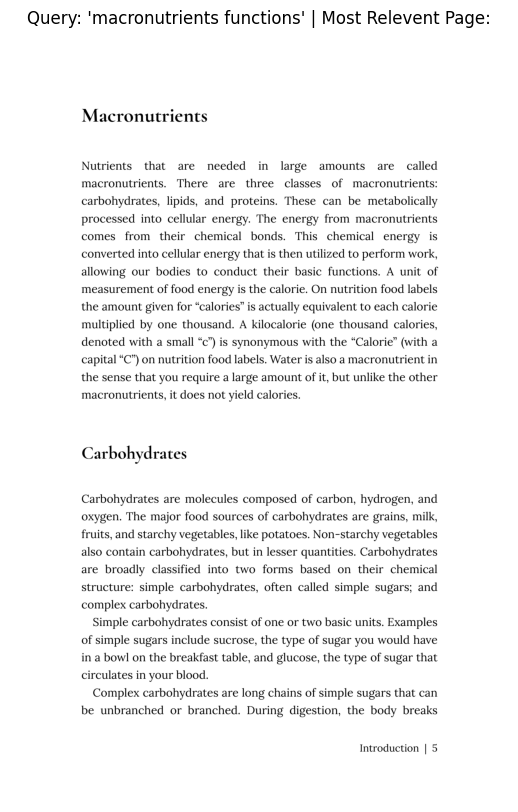

In [ ]:
pdfPath = "human-nutrition-text.pdf"
doc = fitz.open(pdfPath)
page = doc.load_page(5+41)

# Image Of Page
img = page.get_pixmap(dpi = 300)
#img.save("")

doc.close()
imgArray = np.frombuffer(img.samples_mv, dtype = np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(imgArray)
plt.title(f"Query: '{query}' | Most Relevent Page:")
plt.axis("off")
plt.show()

# FUNCTIONIZING OUR SEMENTIC SEARCH PIPELINE
Single Function For All Above Workflow

* Input Query --> Embedding Query --> Get Relevent Indexes back(Page Num)

In [ ]:
def retireval(Query: str,
              embeddings: torch.tensor,
              model: SentenceTransformer=embeddingModel,
              numOfResourcesToReturn: int=5,
              printTime: bool=True):
  'Query Embedding'
  QueryEmbeddings = model.encode(Query, convert_to_tensor=True)
  startTime = timer()
  dotScores = util.dot_score(QueryEmbeddings, embeddingsList)[0]
  endTime = timer()

  if printTime:
    print(f"Time Taken to get scores on {len(embeddingsList)} embeddings: {endTime-startTime:.5f} seconds.")

  scores, indexes = torch.topk(input = dotScores, k = numOfResourcesToReturn)
  return scores, indexes

def displayTopResultsAndScores(Query:str,
                               embeddings: torch.tensor,
                               pages_chunk: list[dict]=pages_chunk,
                               numOfResourcesToReturn: int=5):
  scores, indexes = retireval(Query=Query,
                              embeddings=embeddings,
                              numOfResourcesToReturn=numOfResourcesToReturn)
  for score, idx in zip(scores, indexes):
    print(f"Score: {score:.4f}")
    print("Text:")
    printWrapped(pages_chunk[idx]["sentencesChunk"])
    print(f"Page Number: {pages_chunk[idx]['Page Number']}")
    print("\n")

In [ ]:
Queryy = "Top Protein Resources"
retireval(Queryy, embeddings=embeddingsList)
displayTopResultsAndScores(Queryy, embeddings=embeddingsList)

Time Taken to get scores on 1697 embeddings: 0.00009 seconds.
Time Taken to get scores on 1697 embeddings: 0.00007 seconds.
Score: 0.6751
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds.According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health.It’s the protein package that’s likely to make a
difference.”1 1. Protein: The Bottom Line.Harvard School of Public Proteins,
Diet, and Personal Choices | 411


Page Number: 452


Score: 0.6457
Text:
Foods that contain some of the essential amino acids are called incomplete
protein sources, while those that contain all nine essential amino acids are
called complete protein sources, or high- quality protein sources.Foods that are
complete protein sources include animal foods such as milk, cheese, eggs, fish,
poultry, and meat, and a few plant foods, such as soy and quinoa.The only


# Setting up LLM for local generation

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [ ]:
!pip install -q huggingface_hub
!huggingface-cli login


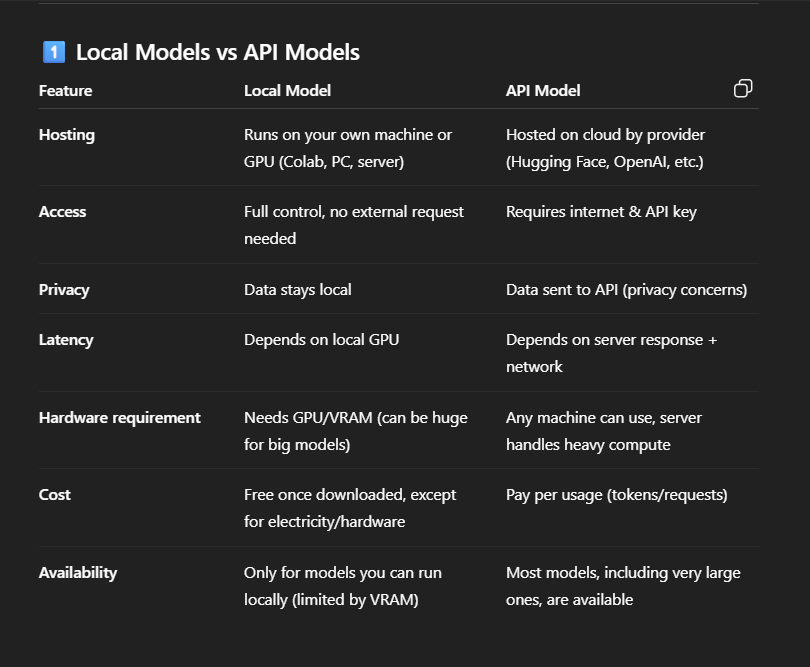

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_id = "google/gemma-2b-it"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    use_auth_token=True
)

print("Gemma 2B loaded successfully!")


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Gemma 2B loaded successfully!


In [ ]:
def getnumOfModelParams(model: torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])
getnumOfModelParams(model)

2506172416

# Generating Text With Loaded LLM locally


In [ ]:
sampleInputText = "What are the macronutrients, and what roles they play in the human body"
# Creating prompt template for instruction turned model
dialogueTemplate = [
    {"role": "user",
     "content": sampleInputText}
]
print(f"Input text:\n{sampleInputText}")
# Applying Chat Template
prompt = tokenizer.apply_chat_template(conversation=
                                       dialogueTemplate,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt Template (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles they play in the human body

Prompt Template (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles they play in the human body<end_of_turn>
<start_of_turn>model



In [ ]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_wor

In [ ]:
%%time

# Tokenize the sample input text
inputIds = tokenizer(prompt,
                     return_tensors = "pt").to(device)
inputIds

CPU times: user 669 µs, sys: 886 µs, total: 1.56 ms
Wall time: 9.87 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    984,   1554,    575,    573,
           3515,   2971,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0')}

In [ ]:
%%time
outputs = model.generate(**inputIds,max_new_tokens = 256)
print(f"Output:\n{tokenizer.decode(outputs[0])}")

Output:
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles they play in the human body<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Provide energy for the body's cells and tissues. They are the primary source of energy for most organs and tissues, including muscles, brain, and red blood cells.
* **Protein:** Builds and repairs tissues, enzymes, hormones, and antibodies. It also helps regulate blood sugar levels and immune function.
* **Fat:** Provides energy, helps absorb vitamins, and helps insulate the body. It also plays a role in hormone production and cell signaling.

**Micronutrients:**

* **Calcium:** Essential for strong bones and teeth, muscle contraction, and nerve function.
* **Iron:** Involved in red blood cell production, oxygen transport, and immune function.
* **Vitamin D:** Important for calcium absorption, bone health, and immune func

# FINAL STEP: AUGMENTING PROMPT WITH CONTEXT ITEMS (Prompt Engineering)

### Prompting Techniques:
1) Give a Clear Instruction
2) Give a few example of ip/op(few shot learning)
3) Give Room To Think



In [ ]:
def prompt_formatter(Query: str,
                     context_items: list[dict]) -> str:

    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentencesChunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""


    base_prompt = base_prompt.format(context=context, query=query)


    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
Query = random.choice(query_list)
#Query = "How much a normal person should eat?"
print(f"Query: {Query}")

# Get relevant resources
scores, indexes = retireval(Query=Query,embeddings=embeddings)

# Create a list of context items
context_items = [pages_chunks[i] for i in indexes]

# Format prompt with context items
prompt = prompt_formatter(Query= Query,
                          context_items=context_items)
print(prompt)

Query: How do vitamins and minerals differ in their roles and importance for health?
Time Taken to get scores on 1697 embeddings: 0.00010 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is 

In [ ]:
%%time

input_ids = tokenizer(Query, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True,
                             max_new_tokens=256) # how many new tokens to generate from prompt

output_text = tokenizer.decode(outputs[0])

print(f"Query: {Query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Explain the concept of energy balance and its importance in weight management.
RAG answer:
<bos>Explain the concept of energy balance and its importance in weight management.

Sure, here's an explanation of the concept of energy balance and its importance in weight management:

**Energy Balance:**

Energy balance refers to the overall amount of energy intake and expenditure within an individual's body. It determines whether the body has enough energy to meet its physiological needs, including growth, tissue repair, and metabolic processes.

**Importance of Energy Balance for Weight Management:**

1. **Maintenance of Body Weight:**
   - Energy balance plays a crucial role in maintaining body weight. When energy intake exceeds expenditure, the body stores excess energy in adipose tissue, leading to weight gain. Conversely, when energy expenditure exceeds intake, the body burns fat and muscle tissue, resulting in weight loss.

2. **Fueling Muscle Growth and Repair:**
   - During mu

# Functionizing Our LLM Answering Feature


In [ ]:
def ask(Query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    # Get just the scores and indices of top related results
    scores, indixes = retireval(Query=Query, embeddings=embeddingsList)

    # Create a list of context items
    context_items = [pages_chunk[i] for i in indexes]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # Format the prompt with context items
    prompt = prompt_formatter(Query=Query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Returns the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
Query = random.choice(query_list)
print(f"Query: {Query}")

# Answer query with context and return context
answer, context_items = ask(Query=Query,
                            temperature=0.7,
                            max_new_tokens=512,
                            format_answer_text=True,
                            return_answer_only=False)

print(f"Answer:\n")
printWrapped(answer)
print(f"Context items:")
context_items

Query: water soluble vitamins
Time Taken to get scores on 1697 embeddings: 0.00010 seconds.
Answer:

The context does not provide any information about the difference between
vitamins and minerals in their roles and importance for health, so I cannot
answer this question from the provided context.


Context items:


[{'Page Number': 52,
  'sentencesChunk': 'Vitamins Major Functions Water-soluble Thiamin (B1) Coenzyme, energy metabolism assistance Riboflavin (B2 ) Coenzyme, energy metabolism assistance Niacin (B3) Coenzyme, energy metabolism assistance Pantothenic acid (B5) Coenzyme, energy metabolism assistance Pyridoxine (B6) Coenzyme, amino acid synthesis assistance Biotin (B7) Coenzyme, amino acid and fatty acid metabolism Folate (B9) Coenzyme, essential for growth Cobalamin (B12) Coenzyme, red blood cell synthesis C (ascorbic acid) Collagen synthesis, antioxidant Fat-soluble A Vision, reproduction, immune system function D Bone and teeth health maintenance, immune system function E Antioxidant, cell membrane protection K Bone and teeth health maintenance, blood clotting Vitamin deficiencies can cause severe health problems and even death.For example, a deficiency in niacin causes a disease called pellagra, which was common in the early twentieth century in some parts of America.The common sign

In [218]:
import nbformat
import glob

for nb_path in glob.glob("*.ipynb"):
    with open(nb_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)
    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]
    with open(nb_path, "w", encoding="utf-8") as f:
        nbformat.write(nb, f)
    print(f"Cleaned {nb_path}")
